# Historical Flight Network Analysis

Data obtained from https://openflights.org/data.html

In [2]:
import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
# from matplotlib import collections as mc
#from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

from bokeh.io import show, output_notebook
from bokeh.plotting import figure
from bokeh.models import GraphRenderer, StaticLayoutProvider
from bokeh.models import WMTSTileSource
from bokeh.models.glyphs import MultiLine

In [5]:
from IPython.display import Image

In [2]:
output_notebook()

Loading BokehJS ...

In [3]:
data_dir = 'data/'

Data obtained from https://openflights.org/data.html  
In the following process, data at 1988 and 2008 has been mainly used.

In [4]:
df_test = pd.read_csv(data_dir+'1987.csv.bz2', chunksize=100)
df = df_test.get_chunk()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 29 columns):
Year                 100 non-null int64
Month                100 non-null int64
DayofMonth           100 non-null int64
DayOfWeek            100 non-null int64
DepTime              97 non-null float64
CRSDepTime           100 non-null int64
ArrTime              97 non-null float64
CRSArrTime           100 non-null int64
UniqueCarrier        100 non-null object
FlightNum            100 non-null int64
TailNum              0 non-null float64
ActualElapsedTime    97 non-null float64
CRSElapsedTime       100 non-null int64
AirTime              0 non-null float64
ArrDelay             97 non-null float64
DepDelay             97 non-null float64
Origin               100 non-null object
Dest                 100 non-null object
Distance             100 non-null int64
TaxiIn               0 non-null float64
TaxiOut              0 non-null float64
Cancelled            100 non-null int64
Cancella

In [5]:
df = []
for year in range(1987, 2009):
    try:
        df_ = pd.read_csv(data_dir+str(year)+'.csv.bz2', 
                          encoding='utf-8')
    except:
        df_ = pd.read_csv(data_dir+str(year)+'.csv.bz2', 
                          encoding='latin-1')
    df_ = df_[df_.Diverted == 0].loc[:, ['Year', 'Origin', 'Dest']]
    
    df_0 = df_.loc[:, ['Origin', 'Dest']]
    df_.loc[:, ['Origin']] = df_0.loc[:, ['Origin', 'Dest']].min(axis=1)
    df_.loc[:, ['Dest']] = df_0.loc[:, ['Origin', 'Dest']].max(axis=1)
    
    df_ = df_.groupby(df_.columns.tolist()).size().reset_index().rename(columns={0:'COUNT'})
    df.append(df_)
    del(df_, df_0)
    print("{} data hasbeen successfully loaded".format(year))

df_flight_net = pd.concat(df, ignore_index=True, sort=False)
del(df)

1987 data hasbeen successfully loaded
1988 data hasbeen successfully loaded
1989 data hasbeen successfully loaded
1990 data hasbeen successfully loaded
1991 data hasbeen successfully loaded
1992 data hasbeen successfully loaded
1993 data hasbeen successfully loaded
1994 data hasbeen successfully loaded
1995 data hasbeen successfully loaded
1996 data hasbeen successfully loaded
1997 data hasbeen successfully loaded
1998 data hasbeen successfully loaded
1999 data hasbeen successfully loaded
2000 data hasbeen successfully loaded
2001 data hasbeen successfully loaded
2002 data hasbeen successfully loaded


/home/jeong/.env/incubator/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2003 data hasbeen successfully loaded
2004 data hasbeen successfully loaded
2005 data hasbeen successfully loaded
2006 data hasbeen successfully loaded
2007 data hasbeen successfully loaded
2008 data hasbeen successfully loaded


To avoid memory overflow, keep only essential columns of the data for network analysis.

In [6]:
df_airports = pd.read_csv(data_dir + 'airports.dat', delimiter=',', header=None, index_col=0)
df_airports.columns = pd.Index(['NAME', 'CITY', 'COUNTRY', 'IATA', 'ICAO', 'LATITUDE',
       'LONGITUDE', 'ALTITUDE', 'TIMEZONE', 'DST', 'TZ_DATABASE', 'TYPE',
       'SOURCE'],
      dtype='object')

To read airport information, load another data file

In [7]:
us_airports = df_airports[df_airports.COUNTRY == 'United States']
condition1 = df_flight_net.Origin.isin(us_airports.IATA.values)
condition2 = df_flight_net.Dest.isin(us_airports.IATA.values)
df_flight_net = df_flight_net[condition1 & condition2]

In [8]:
linked_port = list(set(np.hstack((df_flight_net.Origin.values, 
                                  df_flight_net.Dest.values))))
port_dict = dict()
for i in range(len(linked_port)):
    port_dict[linked_port[i]] = i
df_flight_net['Depart'] = df_flight_net.Origin.map(port_dict)
df_flight_net['Arrive'] = df_flight_net.Dest.map(port_dict)

For the convenience, give the identical number to every airport

In [9]:
df_flight_net['origin_lon'] = [float(df_airports.LONGITUDE[
    df_airports.IATA == x].values) for x in df_flight_net.Origin]
df_flight_net['origin_lat'] = [float(df_airports.LATITUDE[
    df_airports.IATA == x].values) for x in df_flight_net.Origin]
df_flight_net['dest_lon'] = [float(df_airports.LONGITUDE[
    df_airports.IATA == x].values) for x in df_flight_net.Dest]
df_flight_net['dest_lat'] = [float(df_airports.LATITUDE[
    df_airports.IATA == x].values) for x in df_flight_net.Dest]

Read geographic position of airports from airport data

In [10]:
def wgs84_to_web_mercator(df, lon="lon", lat="lat"):
    """Change Longitude and Latitude to web mercador number"""
    k = 6378137
    df["x"] = df[lon] * (k * np.pi/180.0)
    df["y"] = np.log(np.tan((90 + df[lat]) * np.pi/360.0)) * k
    return df

In [11]:
def line_df_to_xy(df):
    """From Dataframe, read the coordinates 
    and transform to position pair to build line segments"""
    df_origin = df.loc[:, ['origin_lon', 'origin_lat']]
    df_dest = df.loc[:, ['dest_lon', 'dest_lat']]

    wgs84_to_web_mercator(df_origin, lon='origin_lon', lat='origin_lat')
    wgs84_to_web_mercator(df_dest, lon='dest_lon', lat='dest_lat')

    xs = list(zip(df_origin['x'].values, df_dest['x']))
    ys = list(zip(df_origin['y'].values, df_dest['y']))
    return xs, ys

In [58]:
def background_map():
    """Load the US map"""
    USA = x_range,y_range = ((-14084029,-7753304), (2698291, 6555972))
    p = figure(tools='pan, wheel_zoom', x_range=x_range, y_range=y_range, 
               x_axis_type="mercator", y_axis_type="mercator")

    url = 'http://a.basemaps.cartocdn.com/rastertiles/voyager/{Z}/{X}/{Y}.png'
    attribution = "Tiles by Carto, under CC BY 3.0. Data by OSM, under ODbL"

    p.add_tile(WMTSTileSource(url=url, attribution=attribution))

    p = figure(tools='pan, wheel_zoom', x_range=x_range, y_range=y_range, 
               x_axis_type="mercator", y_axis_type="mercator", 
               x_axis_label='Longitude', y_axis_label='Latitude')

    p.add_tile(WMTSTileSource(url=url, attribution=attribution))

    return p

In [59]:
def network_map(df, alpha=0.5):
    """add line segments to the figure, p"""
    xs, ys = line_df_to_xy(df)
    p = background_map()
    p.multi_line(xs=xs, ys=ys, line_color='red', 
                 line_width=0.1, line_alpha=alpha)

    return p

In [ ]:
show(network_map(df_flight_net[df_flight_net.Year == 1988]))

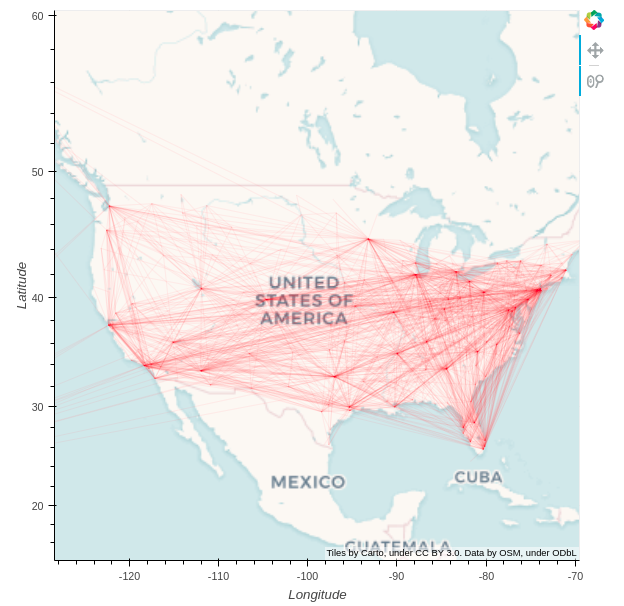

In [6]:
Image('images/1988.png')

This is the flight network at 1988.

In [ ]:
show(network_map(df_flight_net[df_flight_net.Year == 2008]))

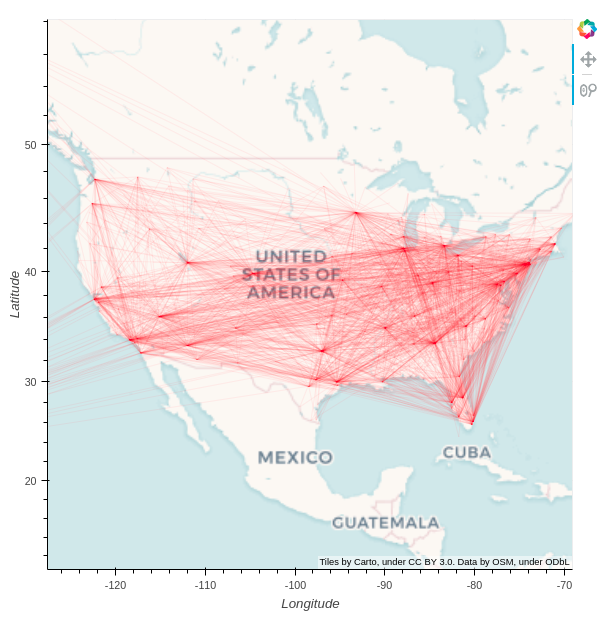

In [7]:
Image('images/2008.png')

Here is another figure. This is the flight network map at 2008.  
Connection is more dense than network at 1988.

In [62]:
def df_diff(df1, df2):
    drop_index = []
    for i in range(len(df1)):
        for o, d in zip(df1.Origin.values, df2.Dest.values):
            if (df1.Origin.values[i] == o) & (df1.Dest.values[i] == d):
                drop_index.append(i)
    df_ = df1.copy()
    return df_.drop(df_.index.values[drop_index])

In [63]:
condition1988 = (df_flight_net.Year == 1988)
condition2008 = (df_flight_net.Year == 2008)
df_1988 = df_flight_net[condition1988].drop(columns=['Year', 'COUNT'])
df_2008 = df_flight_net[condition2008].drop(columns=['Year', 'COUNT'])

df_diff1 = df_diff(df_2008, df_1988)
df_diff2 = df_diff(df_1988, df_2008)

In [ ]:
p = network_map(df_diff1, alpha=1)
xs, ys = line_df_to_xy(df_diff2)
p.multi_line(xs=xs, ys=ys, line_color='blue', 
             line_width=0.1, line_alpha=0.7)
show(p)

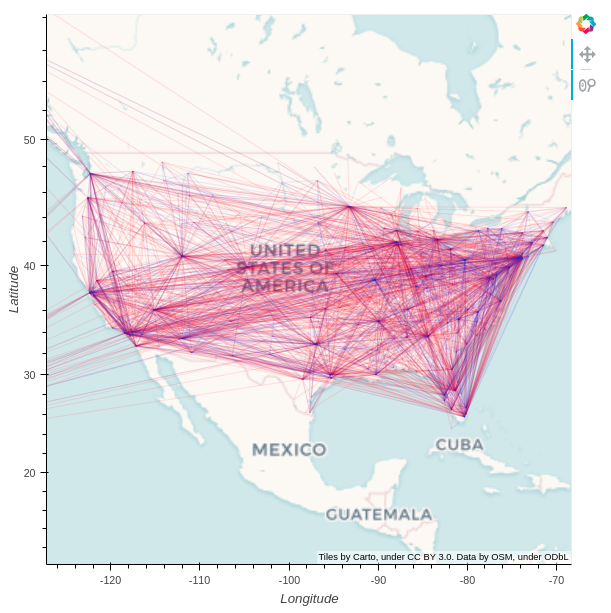

In [8]:
Image('images/diff.png')

"Red" lines are flight connection of 2008 which didn't exist at 1988, while "Blue" lines are flight connection of 1988 had been deleted before 2008.

In [65]:
def list_to_matrix(dept, arr, size_mat, z_value=1, symmetric=True, cnt=True):
    try:
        len(z_value)
    except:
        z_value = np.full((len(dept)), z_value)

    matrix = np.zeros((size_mat, size_mat))
    
    k=0
    for i, j in zip(dept, arr):
        if cnt:
            matrix[i,j] += z_value[k]
        else:
            matrix[i,j] = z_value[k]
        k += 1
    if symmetric:
        matrix = matrix + matrix.transpose()
    return matrix

In [20]:
edge_matrix_count = list_to_matrix(df_flight_net.Depart.values, 
                                   df_flight_net.Arrive.values, 
                                   len(port_dict), 
                                   z_value=df_flight_net.COUNT.values)

In [21]:
edge_matrix = list_to_matrix(df_flight_net.Depart.values, 
                                   df_flight_net.Arrive.values, 
                                   len(port_dict),
                                   z_value=1)

In [22]:
print("Total number of airports in the data = {}".format(len(port_dict)))

Total number of airports in the data = 335


In [23]:
print("Number of every kind of cennection = {}".format(np.count_nonzero(edge_matrix)))

Number of every kind of cennection = 8288


In [24]:
print("Total number of flights in the US from 1987 to 2009 = {}".format(edge_matrix_count.sum()))

Total number of flights in the US from 1987 to 2009 = 244232402.0


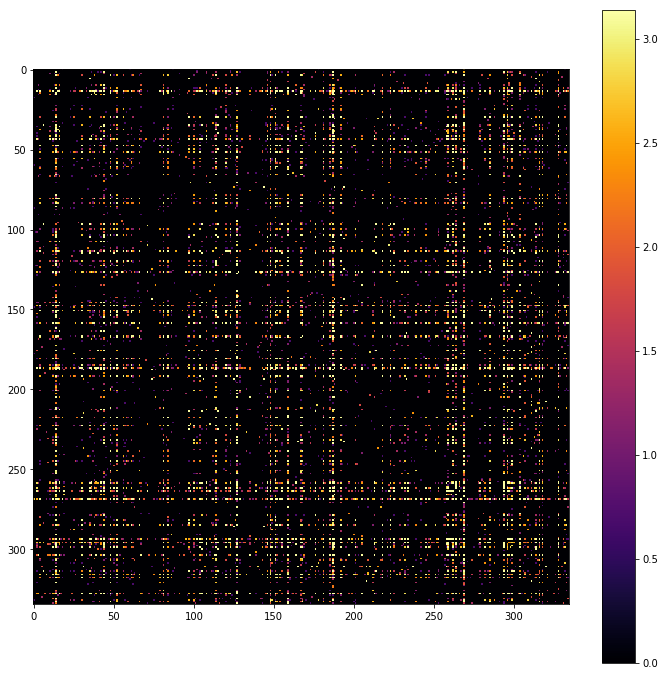

In [25]:
plt.figure(figsize=(12,12))
plt.imshow(np.log(edge_matrix+1) , cmap='inferno')
plt.colorbar()
plt.show()

This figure is the connection map from 1987 to 2009.  
x-axis and y-axis are airport identification numbers. Every pixel denotes a flight route from 'x' airport to 'y' airport. And the brightness tells us how many years the connection kept. For example, in the position (x, y) = (50, 200), if the pixel is black colored, it means there are no flight between 'airport 50' and 'airport 200' for the whole time form 1987 to 2009. Some bright horizontal or vertical lines mean big hub airports. 

In [26]:
def route_sort(network):
    order = np.argsort(np.sum(network, axis=0))

    network = network[:, order]
    network = network[order, :]
    return network

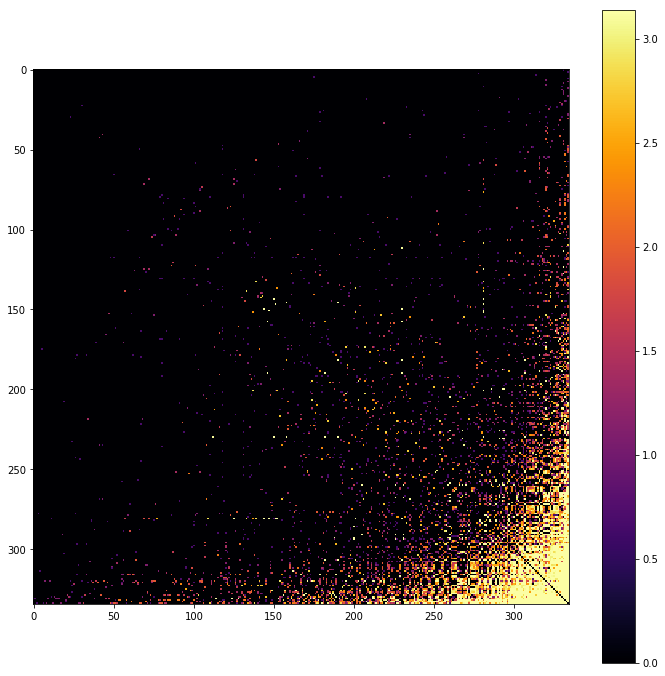

In [27]:
plt.figure(figsize=(12,12))
plt.imshow(np.log(route_sort(edge_matrix) +1), cmap='inferno')
plt.colorbar()
plt.show()

Sorted by the number of flight route of each airport. One can see the distribution of the connections is extremely focused on a few airports. This is typical behaviour of complex network.

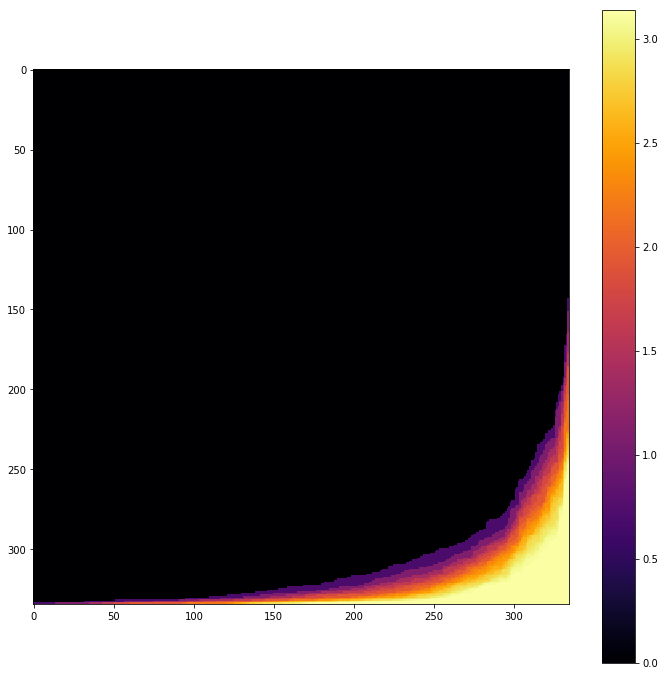

In [28]:
plt.figure(figsize=(12,12))
plt.imshow(np.log(np.sort(np.sort(edge_matrix, axis=0)) +1), cmap='inferno')
plt.colorbar()
plt.show()

In [30]:
def net_to_list(net):
    start_pt = []
    end_pt = []
    for i in range(len(net)):
        for j in range(len(net)):
            if net[i,j] >0 :
                start_pt.append(i)
                end_pt.append(j)
    return start_pt, end_pt

In [31]:
def chord(n_node, nodes_start, nodes_end, alpha=0.03, 
          title="Non-riboon Chord diagram"):

    plot = figure(title=title, x_range=(-1.1,1.1), y_range=(-1.1,1.1),
                  tools="", toolbar_location=None)

    graph = GraphRenderer()

    graph.node_renderer.data_source.add(range(n_node), 'index')
    #graph.node_renderer.glyph = Oval(height=0.1, width=0.2)

    graph.edge_renderer.data_source.data = dict(start=nodes_start, 
                                                end=nodes_end)
    graph.edge_renderer.glyph = MultiLine(line_color="#ff0000", 
                                          line_alpha=alpha, 
                                          line_width=1)

    ### start of layout code
    circ = [i*2*math.pi / n_node for i in range(n_node)]
    x = [math.cos(i) for i in circ]
    y = [math.sin(i) for i in circ]
    graph_layout = dict(zip(range(n_node), zip(x, y)))
    graph.layout_provider = StaticLayoutProvider(graph_layout=graph_layout)

    ### Draw quadratic bezier paths
    def bezier(start, end, control, steps):
        return [(1-s)**2*start + 2*(1-s)*s*control + 
                s**2*end for s in steps]

    xs, ys = [], []
    for i, j in zip(nodes_start, nodes_end):
        sx, sy = graph_layout[i]
        steps = [i/100. for i in range(100)]

        ex, ey = graph_layout[j]
        xs.append(bezier(sx, ex, 0, steps))
        ys.append(bezier(sy, ey, 0, steps))

    graph.edge_renderer.data_source.data['xs'] = xs
    graph.edge_renderer.data_source.data['ys'] = ys

    plot.renderers.append(graph)

    return plot

In [ ]:
start_point, end_point = net_to_list(edge_matrix)
show(chord(len(port_dict), start_point, end_point, title='Airline connection'))

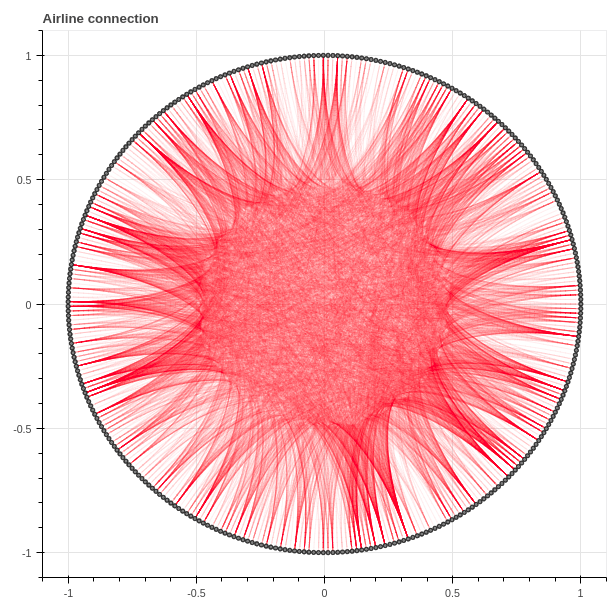

In [12]:
Image('images/chord_unsorted.png')

Every node denotes an airport. It is hard to see any property.

In [ ]:
start_point, end_point = net_to_list(route_sort(edge_matrix))
show(chord(len(port_dict), start_point, end_point, title='Sorted Airline connection'))

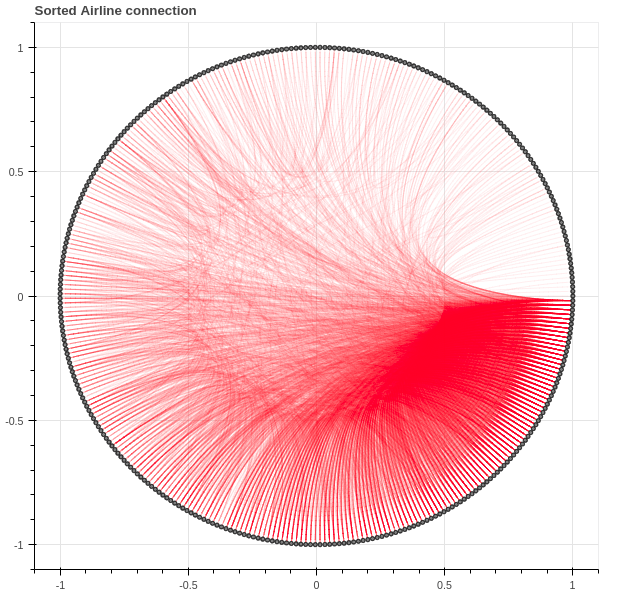

In [13]:
Image('images/chord_sorted.png')

Sorted graph. It looks like there is certain drag force to the hub airport direction. 